# The bidirectional role of DTA mutational burden on MDS outcomes: a retrospective study and machine learning analysis

# Basic packages

In [66]:
import numpy as np
import pandas as pd
#import i2bmi

In [67]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)

# Data Loading and Preprocessing

In [99]:
### Load data using saved csv file (created based on SQL query)

from pathlib import Path

# Folder where this script lives 
HERE = Path.cwd()

# Project root -> go one level up from HERE
PROJECT_ROOT = HERE.parent


# Get paths to the data output folders
OUTPUT = PROJECT_ROOT / "output"
FIGURES = PROJECT_ROOT / "figures"
DATA = PROJECT_ROOT / "data"

df1 = pd.read_csv(OUTPUT / "mds_dta_all_mds_fromsql.csv")
df1.head()

,patient_id,sample_id,os_months,os_status,lfs_months,lfs_status,sex,age,mds_type,who_2016,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,cyto_ipssr,complex_karyotype,tp53_altered,flt3_itd,mll_ptd,ipssr,ipssr_score,ipmms,ipmms_score,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,vaf_avg,revel_avg,cadd_avg,phylop_avg
0,E-H-118435,E-H-118435-T1-1-D1-1,23.868493,0:LIVING,23.868493,0:LeukemiaFree,Male,87.0,primary,MDS-MLD,1.0,0.0,7.5,80.0,3.38,2.80,0.50,Good,non-complex,0,False,False,Low,3.0,Moderate-Low,-0.44,13.047761,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,38.84,NaN,NaN,NaN
1,E-H-102590,E-H-102590-T1-1-D1-1,7.134247,1:DECEASED,7.134247,1:Transformed/Deceased,Male,91.0,primary,MDS-RS-SLD,1.0,0.0,7.7,203.0,9.70,4.75,0.72,Very-Good,non-complex,0,False,False,Very-Low,1.5,Low,-0.76,13.047761,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41.00,NaN,NaN,NaN
2,E-H-102764,E-H-102764-T1-1-D1-1,13.117808,0:LIVING,13.117808,0:LeukemiaFree,Male,55.0,primary,MDS-EB2,14.5,0.0,8.8,31.0,3.60,2.40,0.10,Good,non-complex,0,False,False,High,6.0,High,0.77,15.222388,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.69,NaN,NaN,NaN
3,E-H-110868,E-H-110868-T1-1-D1-1,49.742466,0:LIVING,49.742466,0:LeukemiaFree,Female,78.0,primary,MDS-EB1,6.0,0.0,14.0,125.0,3.30,0.89,0.20,Good,non-complex,0,False,False,Low,3.0,Low,-0.71,17.397015,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,43.76,NaN,23.3,8.80
4,E-H-106013,E-H-106013-T1-1-D1-1,18.805479,0:LIVING,18.805479,0:LeukemiaFree,Male,88.0,primary,MDS-RS-SLD,1.0,0.0,8.6,139.0,5.90,4.40,NaN,Good,non-complex,0,False,False,Low,2.0,Low,-0.69,6.523881,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.61,0.89,32.0,8.78


In [69]:
# Missing values
df1.isnull().sum()

patient_id                      0
sample_id                    1323
os_months                     150
os_status                     150
lfs_months                    528
lfs_status                    528
sex                             0
age                            20
mds_type                      186
who_2016                       86
bm_blast                      108
pb_blast                      625
hbg                           109
plt                           122
wbc                           269
anc                           190
monocytes                     595
cyto_ipssr                    144
complex_karyotype               0
tp53_altered                    0
flt3_itd                        0
mll_ptd                         0
ipssr                         218
ipssr_score                   331
ipmms                         618
ipmms_score                   618
tmb_nonsynonymous               0
asxl1                        1323
dnmt3a                       1323
tet2          

# OR

### Connecting to SQL to gather cohort

In [70]:
#pip install python-dotenv
#mamba install sqlalchemy psycopg2-binary pycopg[binary] pandas #in Terminal


In [71]:
import os
from dotenv import load_dotenv
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine, text
import getpass

# Clear any existing PG_* environment variables first
for key in list(os.environ.keys()):
    if key.startswith('PG_'):
        del os.environ[key]

# Load environment variables from .env file
load_dotenv(override=True)  # override=True ensures .env values take precedence

# Check what was loaded (for debugging purposes)
#print(f"PG_USER from env: {os.getenv('PG_USER')}")
#print(f"PG_HOST from env: {os.getenv('PG_HOST')}")
#print(f"PG_PORT from env: {os.getenv('PG_PORT')}")
#print(f"PG_DB from env: {os.getenv('PG_DB')}")

# Prompt for secure password input (already stored in Terminal in my personal .env file)
url = URL.create(
    drivername="postgresql+psycopg",
    username=os.getenv("PG_USER"),
    password=os.getenv("PG_PASSWORD"),
    host=os.getenv("PG_HOST"),
    port=os.getenv("PG_PORT"),
    database=os.getenv("PG_DB"),)

# Create the SQLAlchemy engine with SSL disabled
engine = create_engine(url, connect_args={"sslmode": "disable"}) # SSL disabled for local connections

# Connection
with engine.connect() as c:
    df1 = pd.read_sql(text("SELECT * FROM final_project.cohort_ml_v4;"), c)

df1.head()

,patient_id,sample_id,os_months,os_status,lfs_months,lfs_status,sex,age,mds_type,who_2016,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,cyto_ipssr,complex_karyotype,tp53_altered,flt3_itd,mll_ptd,ipssr,ipssr_score,ipmms,ipmms_score,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,vaf_avg,revel_avg,cadd_avg,phylop_avg
0,E-H-118435,E-H-118435-T1-1-D1-1,23.86849315,0:LIVING,23.86849315,0:LeukemiaFree,Male,87,primary,MDS-MLD,1,0,7.5,80,3.38,2.8,0.5,Good,non-complex,0,FALSE,FALSE,Low,3,Moderate-Low,-0.44,13.04776133,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,38.84,NaN,NaN,NaN
1,E-H-102590,E-H-102590-T1-1-D1-1,7.134246575,1:DECEASED,7.134246575,1:Transformed/Deceased,Male,91,primary,MDS-RS-SLD,1,0,7.7,203,9.7,4.75,0.72,Very-Good,non-complex,0,FALSE,FALSE,Very-Low,1.5,Low,-0.76,13.04776133,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,41.00,NaN,NaN,NaN
2,E-H-102764,E-H-102764-T1-1-D1-1,13.11780822,0:LIVING,13.11780822,0:LeukemiaFree,Male,55,primary,MDS-EB2,14.5,0,8.8,31,3.6,2.4,0.1,Good,non-complex,0,FALSE,FALSE,High,6,High,0.77,15.22238822,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.69,NaN,NaN,NaN
3,E-H-110868,E-H-110868-T1-1-D1-1,49.74246575,0:LIVING,49.74246575,0:LeukemiaFree,Female,78,primary,MDS-EB1,6,0,14,125,3.3,0.89,0.2,Good,non-complex,0,FALSE,FALSE,Low,3,Low,-0.71,17.39701511,0.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,43.76,NaN,23.3,8.80
4,E-H-106013,E-H-106013-T1-1-D1-1,18.80547945,0:LIVING,18.80547945,0:LeukemiaFree,Male,88,primary,MDS-RS-SLD,1,0,8.6,139,5.9,4.4,NA,Good,non-complex,0,FALSE,FALSE,Low,2,Low,-0.69,6.523880665,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,49.61,0.89,32.0,8.78


In [72]:
df1['os_months'].describe() 
# since there is a month = 0, we will add 0.1 to all months to avoid issues with log(0)

count     3300
unique    1649
top         NA
freq       150
Name: os_months, dtype: object

## Columns/ variables

In [73]:
### Data for ML model - patient ID and sample ID are not included

dff=df1[['os_months', 'os_status', 'lfs_months', 'lfs_status', # outcomes variables
        'sex','age','mds_type', # demographics
        'bm_blast','pb_blast','hbg','plt','wbc','anc','monocytes', # lab values/ known prognostic variables
        'complex_karyotype','flt3_itd','mll_ptd','tmb_nonsynonymous', # genomic variables
        'asxl1','dnmt3a','tet2', # DTA genes presence/absence
        'asxl1_count','dnmt3a_count','tet2_count','n_dta','n_different_dta', # DTA gene mutation counts
        'truncating_variant','asxl1_truncating_variant', # truncating variants
        'dnmt3a_truncating_variant','tet2_truncating_variant','n_truncating_variant', # truncating variants
        'pathogenic_asxl1','pathogenic_dnmt3a','pathogenic_tet2', # pathogenic DTA mutations
        'revel_avg','cadd_avg','phylop_avg']] # DTA mutation computational scores

## Fix outcomes formatting

In [74]:
### Pre-processing - dummies (1 means deceased/ transformed to leukemia)
cols = ['os_status', 'lfs_status']

for c in cols:
    dff[c] =(
        dff[c]
        .astype(str)
        .str.strip()
        .str.replace(r':.*', '', regex=True)   # drop everything from first ":" onward
        .pipe(pd.to_numeric, errors='coerce')  # to numbers (bad/missing becomes NaN)
        .astype('Int64')                       # nullable integer
        )

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/1478443110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[c] =(
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/1478443110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[c] =(


## Formatting variables

In [75]:
### Convert continuous variables to numeric and round to 2 decimals

continuous = ['age','bm_blast','pb_blast','hbg','plt','wbc','anc','monocytes',
              'tmb_nonsynonymous',
              'asxl1_count','dnmt3a_count','tet2_count','n_dta','n_different_dta']

for col in continuous:
    dff[col] = pd.to_numeric(dff[col], errors='coerce').round(decimals=2)

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/953676407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[col] = pd.to_numeric(dff[col], errors='coerce').round(decimals=2)


In [76]:
### Fill NA values in DTA-related columns with 0

dta_columns = ["asxl1","dnmt3a","tet2","asxl1_count","dnmt3a_count","tet2_count","n_dta","n_different_dta",
               "truncating_variant","asxl1_truncating_variant","dnmt3a_truncating_variant","tet2_truncating_variant","n_truncating_variant",
               "pathogenic_asxl1","pathogenic_dnmt3a","pathogenic_tet2"]

dff[dta_columns] = dff[dta_columns].fillna(0)

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/3595784793.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[dta_columns] = dff[dta_columns].fillna(0)


In [77]:
### Treat certain columns as integers (since they were previously boolean)
to_be_integer = ['asxl1','dnmt3a','tet2','truncating_variant','asxl1_truncating_variant','dnmt3a_truncating_variant','tet2_truncating_variant','n_truncating_variant','pathogenic_asxl1','pathogenic_dnmt3a','pathogenic_tet2']

for col in to_be_integer:
    if col in dff.columns:
        dff[col] = dff[col].astype(int)

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/648123741.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[col] = dff[col].astype(int)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/648123741.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[col] = dff[col].astype(int)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/648123741.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [78]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   os_months                  3300 non-null   object 
 1   os_status                  3150 non-null   Int64  
 2   lfs_months                 3300 non-null   object 
 3   lfs_status                 2772 non-null   Int64  
 4   sex                        3300 non-null   object 
 5   age                        3280 non-null   float64
 6   mds_type                   3300 non-null   object 
 7   bm_blast                   3192 non-null   float64
 8   pb_blast                   2675 non-null   float64
 9   hbg                        3191 non-null   float64
 10  plt                        3178 non-null   float64
 11  wbc                        3031 non-null   float64
 12  anc                        3110 non-null   float64
 13  monocytes                  2705 non-null   float

# Feature Engineering

In [79]:
### Grouping based on ASXL1 status since this can be relevant for prognosis

for g in ["asxl1", "dnmt3a", "tet2"]:
    dff[g] = dff[g].fillna(0).astype(int)

def dta_group(row):
    a, d, t = row["asxl1"], row["dnmt3a"], row["tet2"]

    # ASXL1 only
    if (a == 1) and (d == 0) and (t == 0):
        return "asxl1_only"

    # non-ASXL1 (DNMT3A and/or TET2 only, NO ASXL1)
    if (a == 0) and ((d == 1) or (t == 1)):
        return "non_asxl1"

    # ASXL1 + any other DTA (mixed)
    if (a == 1) and ((d == 1) or (t == 1)):
        return "asxl1_mixed"
    
    # No DTA mutations
    return "no_dta"

dff["dta_group"] = dff.apply(dta_group, axis=1)


/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/1160274449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[g] = dff[g].fillna(0).astype(int)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/1160274449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff[g] = dff[g].fillna(0).astype(int)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/1160274449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [80]:
dff.head()

,os_months,os_status,lfs_months,lfs_status,sex,age,mds_type,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,complex_karyotype,flt3_itd,mll_ptd,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,revel_avg,cadd_avg,phylop_avg,dta_group
0,23.86849315,0,23.86849315,0,Male,87.0,primary,1.0,0.0,7.5,80.0,3.38,2.80,0.50,non-complex,FALSE,FALSE,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,NaN,NaN,NaN,non_asxl1
1,7.134246575,1,7.134246575,1,Male,91.0,primary,1.0,0.0,7.7,203.0,9.70,4.75,0.72,non-complex,FALSE,FALSE,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,NaN,NaN,NaN,non_asxl1
2,13.11780822,0,13.11780822,0,Male,55.0,primary,14.5,0.0,8.8,31.0,3.60,2.40,0.10,non-complex,FALSE,FALSE,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,non_asxl1
3,49.74246575,0,49.74246575,0,Female,78.0,primary,6.0,0.0,14.0,125.0,3.30,0.89,0.20,non-complex,FALSE,FALSE,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,NaN,23.3,8.80,non_asxl1
4,18.80547945,0,18.80547945,0,Male,88.0,primary,1.0,0.0,8.6,139.0,5.90,4.40,NaN,non-complex,FALSE,FALSE,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.89,32.0,8.78,non_asxl1


In [81]:
### Counts for each DTA group

dff["asxl1_only_counts"] = np.where(dff["dta_group"] == "asxl1_only", dff["asxl1_count"], 0)
dff["dta_non_asxl1_counts"] = np.where(dff["dta_group"] == "non_asxl1", dff["dnmt3a_count"] + dff["tet2_count"], 0)
dff["asxl1_mixed_counts"] = np.where(dff["dta_group"] == "asxl1_mixed", dff["asxl1_count"] + dff["dnmt3a_count"] + dff["tet2_count"], 0)

/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/2783329870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["asxl1_only_counts"] = np.where(dff["dta_group"] == "asxl1_only", dff["asxl1_count"], 0)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/T/ipykernel_46885/2783329870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff["dta_non_asxl1_counts"] = np.where(dff["dta_group"] == "non_asxl1", dff["dnmt3a_count"] + dff["tet2_count"], 0)
/var/folders/pf/pdl6qrns3rb_bs1fwh3k77km0000gn/

## `get_dummies` function/ one-hot encoding

In [82]:
### Transform categorical values into dummies (those not already in dummy format)
categorical_cols = ['sex',
                    'mds_type',
                    'complex_karyotype',
                    'flt3_itd',
                    'mll_ptd',
                    'dta_group']
dff = pd.get_dummies(dff, columns=categorical_cols, drop_first=True, dtype=int, dummy_na=True) # drop first to avoid multicollinearity

In [83]:
#df=df.drop(columns=['patient_id', 'sample_id'])  # drop ID columns

# Handling NULL values

In [84]:
### % of missing values per column
missing_percent = dff.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
missing_percent

revel_avg     89.606061
cadd_avg      67.121212
phylop_avg    67.121212
pb_blast      18.939394
monocytes     18.030303
lfs_status    16.000000
wbc            8.151515
anc            5.757576
os_status      4.545455
plt            3.696970
hbg            3.303030
bm_blast       3.272727
age            0.606061
dtype: float64

The decision is to exclude rows with null values in `os_status` and `lfs_status` for each outcome \
Non DTA cases shown as NaN have been filled with zeros \
Variables with > 20% missing will be excluded

### Adding missingness indicators

In [85]:
### Drop columns with more than 20% missing values
cols_to_drop = missing_percent[missing_percent > 20].index.tolist()
dff = dff.drop(columns=cols_to_drop)

In [86]:
### Treat infinite values as NaN
dff.replace([np.inf, -np.inf], np.nan, inplace=True)

## Adding missingness indicators
for col in dff.columns:
    if dff[col].isnull().any():
        dff[col + '_nan'] = dff[col].isnull().astype(int)


In [87]:
dff.head()

,os_months,os_status,lfs_months,lfs_status,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,os_status_nan,lfs_status_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
0,23.86849315,0,23.86849315,0,87.0,1.0,0.0,7.5,80.0,3.38,2.80,0.50,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,0.0,2.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,7.134246575,1,7.134246575,1,91.0,1.0,0.0,7.7,203.0,9.70,4.75,0.72,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,13.11780822,0,13.11780822,0,55.0,14.5,0.0,8.8,31.0,3.60,2.40,0.10,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,49.74246575,0,49.74246575,0,78.0,6.0,0.0,14.0,125.0,3.30,0.89,0.20,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,0.0,2.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,18.80547945,0,18.80547945,0,88.0,1.0,0.0,8.6,139.0,5.90,4.40,NaN,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


# Defining outcomes
#### Outcome 1: os_status and os_months (with censoring) 
#### Outcome 2: lfs_status and lfs_months (with censoring)

In [88]:
### Number of missing values in OS and LFS columns
a=dff['os_status'].isnull().sum()
b=dff['lfs_status'].isnull().sum()
print(f"Number of missing values in os_status: {a}")
print(f"Number of missing values in lfs_status: {b}")

Number of missing values in os_status: 150
Number of missing values in lfs_status: 528


In [89]:
### Drop rows with missing values in either os_status or lfs_status -> divide dataframes and outcomes not related to each other
df_os = dff.dropna(subset=['os_status', 'os_months']).drop(columns=['os_status_nan','lfs_status_nan','lfs_status','lfs_months'])
df_lfs = dff.dropna(subset=['lfs_status', 'lfs_months']).drop(columns=['lfs_status_nan', 'os_status_nan','os_status','os_months'])

In [90]:
### Save dataframes as csv files
df_os.to_csv(OUTPUT / "mds_dta_cohort_os.csv", index=False)
df_lfs.to_csv(OUTPUT / "mds_dta_cohort_lfs.csv", index=False)

# Event-per-variable (EPV) analysis

In [91]:
### Number of rows (patients) in each dataframe
len(df_os), len(df_lfs)

(3150, 2772)

In [92]:
### Counts of event status in each dataframe
a=df_os['os_status'].value_counts()
print(a)
b=df_lfs['lfs_status'].value_counts()
print(b)

os_status
1    1586
0    1564
Name: count, dtype: Int64
lfs_status
1    1466
0    1306
Name: count, dtype: Int64


In [93]:
### Number of columns in each dataframe
len(df_os.columns), len(df_lfs.columns)

(53, 53)

# Demographics

In [94]:
dff.head()

,os_months,os_status,lfs_months,lfs_status,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,os_status_nan,lfs_status_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
0,23.86849315,0,23.86849315,0,87.0,1.0,0.0,7.5,80.0,3.38,2.80,0.50,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,0.0,2.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,7.134246575,1,7.134246575,1,91.0,1.0,0.0,7.7,203.0,9.70,4.75,0.72,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,13.11780822,0,13.11780822,0,55.0,14.5,0.0,8.8,31.0,3.60,2.40,0.10,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,49.74246575,0,49.74246575,0,78.0,6.0,0.0,14.0,125.0,3.30,0.89,0.20,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,0.0,2.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,18.80547945,0,18.80547945,0,88.0,1.0,0.0,8.6,139.0,5.90,4.40,NaN,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [111]:
### Table 2 for Manuscript - Final Version with cleaned categorical variables, labels, and variable order

#mamba install tableone #in Terminal
import pandas as pd
from tableone import TableOne
from openpyxl import *

#  Define categorical + continuous vars
categorical = [
    'sex', 'mds_type', 'complex_karyotype',
    'flt3_itd', 'mll_ptd',
    'asxl1', 'dnmt3a', 'tet2', 'truncating_variant']

continuous = [
    'age','bm_blast','pb_blast','hbg','plt','wbc','anc','monocytes',
    'tmb_nonsynonymous',
    'asxl1_count','dnmt3a_count','tet2_count',
    'n_dta','n_different_dta',
    'asxl1_truncating_variant','dnmt3a_truncating_variant','tet2_truncating_variant',
    'pathogenic_asxl1','pathogenic_dnmt3a','pathogenic_tet2']

# Convert continuous to numeric (coercion)
for col in continuous:
    df1[col] = pd.to_numeric(df1[col], errors="coerce")


#  Human-readable labels
labels = {
    'age': 'Age (years)',
    'sex': 'Sex',
    'mds_type': 'MDS subtype',
    'complex_karyotype': 'Complex karyotype',
    'flt3_itd': 'FLT3–ITD',
    'mll_ptd': 'MLL–PTD',
    'asxl1': 'ASXL1 mutated',
    'dnmt3a': 'DNMT3A mutated',
    'tet2': 'TET2 mutated',
    'truncating_variant': 'Any truncating variant',

    'hbg': 'Hemoglobin (g/dL)',
    'plt': 'Platelets (×10⁹/L)',
    'wbc': 'WBC (×10⁹/L)',
    'anc': 'ANC (×10⁹/L)',
    'monocytes': 'Monocytes (×10⁹/L)',
    'bm_blast': 'Bone marrow blasts (%)',
    'pb_blast': 'Peripheral blood blasts (%)',

    'tmb_nonsynonymous': 'Nonsynonymous TMB',
    'asxl1_count': 'ASXL1 variants (count)',
    'dnmt3a_count': 'DNMT3A variants (count)',
    'tet2_count': 'TET2 variants (count)',
    'n_dta': 'Total DTA variants',
    'n_different_dta': 'Distinct DTA genes mutated',

    'asxl1_truncating_variant': 'ASXL1 truncating variant',
    'dnmt3a_truncating_variant': 'DNMT3A truncating variant',
    'tet2_truncating_variant': 'TET2 truncating variant',

    'pathogenic_asxl1': 'ASXL1 pathogenic',
    'pathogenic_dnmt3a': 'DNMT3A pathogenic',
    'pathogenic_tet2': 'TET2 pathogenic'}

#  Order of variables (by section)
demographics = ['age', 'sex']
clinical_features = ['mds_type']
laboratory_values = ['hbg','plt','wbc','anc','monocytes','bm_blast','pb_blast']
genomic_features = ['complex_karyotype',
    'flt3_itd','mll_ptd',
    'asxl1','dnmt3a','tet2','truncating_variant',
    'tmb_nonsynonymous','asxl1_count','dnmt3a_count','tet2_count',
    'n_dta','n_different_dta',
    'asxl1_truncating_variant','dnmt3a_truncating_variant','tet2_truncating_variant',
    'pathogenic_asxl1','pathogenic_dnmt3a','pathogenic_tet2']

variable_order = (
    demographics +
    clinical_features +
    laboratory_values +
    genomic_features)


#  Generate TableOne
tableS = TableOne(
    data=df1,
    columns=variable_order,
    categorical=categorical,
    rename=labels,
    groupby=None,
    missing=True,
    pval=False,
    label_suffix=True
)

# Convert to DataFrame for editing
df_table = tableS.tableone.copy()

# MultiIndex level 0 labels
level0 = df_table.index.get_level_values(0)

#  Function to insert section header rows
def insert_header(df, header_text, anchor_label):
    """Insert a bold header above the first occurrence of anchor_label."""
    loc = list(level0).index(anchor_label)  # find anchor row
    header_idx = pd.MultiIndex.from_tuples([(header_text, '')])
    header_row = pd.DataFrame({df.columns[0]: [f"**{header_text}**"]},
                              index=header_idx)
    top = df.iloc[:loc]
    bottom = df.iloc[loc:]
    return pd.concat([top, header_row, bottom])

#  Insert section headers
df_table = insert_header(df_table, "Genomic features", "Complex karyotype, n (%)")
df_table = insert_header(df_table, "Laboratory values", "Hemoglobin (g/dL), mean (SD)")
df_table = insert_header(df_table, "Clinical features", "MDS subtype, n (%)")
df_table = insert_header(df_table, "Demographics", "Age (years), mean (SD)")


#  Print + Export
print(df_table)

df_table.to_excel(OUTPUT / "table_2.xlsx")


                                                                  Missing  \
n                                                                           
Demographics                                             **Demographics**   
Age (years), mean (SD)                                                 20   
Sex, n (%)                             Female                               
                                       Male                                 
Clinical features                                   **Clinical features**   
MDS subtype, n (%)                     None                                 
                                       primary                              
                                       s_t_MDS                              
Laboratory values                                   **Laboratory values**   
Hemoglobin (g/dL), mean (SD)                                          109   
Platelets (×10⁹/L), mean (SD)                                         122   

In [ ]:
#mamba install tableone #in Terminal
from tableone import TableOne
from openpyxl import *

# Categorical values for Table 1 based on df1 dataset gathered from SQL query
categorical = ['sex','mds_type','complex_karyotype','flt3_itd','mll_ptd',
                'asxl1','dnmt3a','tet2',
                'truncating_variant']

for col in categorical:
    df1[col] = df1[col].replace({'None': 'Missing value', '0.0': 'No', '1.0': 'Yes'})
    
# Order categories for better readability
order = {var: ["Yes", "No", "Missing value"] for var in categorical}

# Continuous values for Table 1 based on df1 dataset gathered from SQL query
continuous = ['age','bm_blast','pb_blast','hbg','plt','wbc','anc','monocytes',
              'tmb_nonsynonymous',
              'asxl1_count','dnmt3a_count','tet2_count','n_dta','n_different_dta', 
              'asxl1_truncating_variant','dnmt3a_truncating_variant','tet2_truncating_variant',
              'pathogenic_asxl1','pathogenic_dnmt3a','pathogenic_tet2']

for col in continuous:
    df1[col] = pd.to_numeric(df1[col], errors='coerce')
    
# Create Table 1
tableS = TableOne(data=df1,
                  columns=continuous + categorical,
                  categorical=categorical,
                  groupby=None,
                  order=order,
                  pval=False,
                  missing=True,
                  label_suffix=True)

print(tableS.tabulate(tablefmt="fancy_grid"))

# Save Table 1 to Excel file
tableS.to_excel(OUTPUT/"table_1.xlsx")


╒══════════════════════════════════════╤═══════════════╤═══════════╤═══════════════╕
│                                      │               │ Missing   │ Overall       │
╞══════════════════════════════════════╪═══════════════╪═══════════╪═══════════════╡
│ n                                    │               │           │ 3300          │
├──────────────────────────────────────┼───────────────┼───────────┼───────────────┤
│ age, mean (SD)                       │               │ 20        │ 69.7 (12.2)   │
├──────────────────────────────────────┼───────────────┼───────────┼───────────────┤
│ bm_blast, mean (SD)                  │               │ 108       │ 6.0 (7.6)     │
├──────────────────────────────────────┼───────────────┼───────────┼───────────────┤
│ pb_blast, mean (SD)                  │               │ 625       │ 0.9 (4.0)     │
├──────────────────────────────────────┼───────────────┼───────────┼───────────────┤
│ hbg, mean (SD)                       │               │ 109     

/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tableone/formatting.py:184: UserWarning: Order value not found: "sex: ['Yes', 'No']"
  warnings.warn(f'Order value not found: "{k}: {rm_var}"')
/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tableone/formatting.py:184: UserWarning: Order value not found: "mds_type: ['Yes', 'No']"
  warnings.warn(f'Order value not found: "{k}: {rm_var}"')
/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tableone/formatting.py:184: UserWarning: Order value not found: "complex_karyotype: ['Yes', 'No']"
  warnings.warn(f'Order value not found: "{k}: {rm_var}"')
/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tableone/formatting.py:184: UserWarning: Order value not found: "flt3_itd: ['Yes', 'No']"
  warnings.warn(f'Order value not found: "{k}: {rm_var}"')
/Users/pvhernandez/miniforge3/envs/pydev/lib/python3.12/site-packages/tableone/formatting.py:184: UserWarning: Order val

# Stats

In [123]:
dff.head()

,os_months,os_status,lfs_months,lfs_status,age,bm_blast,pb_blast,hbg,plt,wbc,anc,monocytes,tmb_nonsynonymous,asxl1,dnmt3a,tet2,asxl1_count,dnmt3a_count,tet2_count,n_dta,n_different_dta,truncating_variant,asxl1_truncating_variant,dnmt3a_truncating_variant,tet2_truncating_variant,n_truncating_variant,pathogenic_asxl1,pathogenic_dnmt3a,pathogenic_tet2,asxl1_only_counts,dta_non_asxl1_counts,asxl1_mixed_counts,sex_Male,sex_nan,mds_type_primary,mds_type_s_t_MDS,mds_type_nan,complex_karyotype_non-complex,complex_karyotype_nan,flt3_itd_TRUE,flt3_itd_nan,mll_ptd_TRUE,mll_ptd_nan,dta_group_asxl1_only,dta_group_no_dta,dta_group_non_asxl1,dta_group_nan,os_status_nan,lfs_status_nan,age_nan,bm_blast_nan,pb_blast_nan,hbg_nan,plt_nan,wbc_nan,anc_nan,monocytes_nan
0,23.86849315,0,23.86849315,0,87.0,1.0,0.0,7.5,80.0,3.38,2.80,0.50,13.05,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,2,2,0,0,0,0.0,2.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,7.134246575,1,7.134246575,1,91.0,1.0,0.0,7.7,203.0,9.70,4.75,0.72,13.05,0,1,0,0.0,1.0,0.0,1.0,1.0,1,0,1,0,1,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,13.11780822,0,13.11780822,0,55.0,14.5,0.0,8.8,31.0,3.60,2.40,0.10,15.22,0,0,1,0.0,0.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,49.74246575,0,49.74246575,0,78.0,6.0,0.0,14.0,125.0,3.30,0.89,0.20,17.40,0,0,1,0.0,0.0,2.0,2.0,1.0,1,0,0,1,1,0,0,0,0.0,2.0,0.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,18.80547945,0,18.80547945,0,88.0,1.0,0.0,8.6,139.0,5.90,4.40,NaN,6.52,0,1,0,0.0,1.0,0.0,1.0,1.0,0,0,0,0,0,0,1,0,0.0,1.0,0.0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [127]:
### DTA raw counts

# Number of DTA versus non-DTA groups
a = dff['dta_group_no_dta'].value_counts()
print(f'Number of patients in DTA versus non-DTA groups: {a}')
b = dff['dta_group_asxl1_only'].value_counts()
print(f'Number of patients in ASXL1 DTA group: {b}')
c= dff['dta_group_non_asxl1'].value_counts()
print(f'Number of patients in non-ASXL1 DTA group: {c}')

Number of patients in DTA versus non-DTA groups: dta_group_no_dta
0    1977
1    1323
Name: count, dtype: int64
Number of patients in ASXL1 DTA group: dta_group_asxl1_only
0    2759
1     541
Name: count, dtype: int64
Number of patients in non-ASXL1 DTA group: dta_group_non_asxl1
0    2249
1    1051
Name: count, dtype: int64


### Wilcoxon (Mann-Whitney) test 

In [172]:
### Wilcoxon (Mann-Whitney) test for os_months) 

import pandas as pd
from scipy.stats import mannwhitneyu, fisher_exact
from scipy.stats import wilcoxon

TIME_COL = "os_months"
EVENT_COL = "os_status"

#  Start from main dataframe

df = dff.copy()

# Restrict to DTA-positive only
df = df[df["n_dta"] >= 1].copy()

# Define ASXL1 vs Non-ASXL1 and DTA burden groups
df["asxl1_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")
df["burden_group"] = df["n_dta"].apply(lambda x: "<2" if x < 2 else "≥2")

# Coerce to numeric and drop obvious missing
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")

df_clean = df.dropna(subset=[TIME_COL, EVENT_COL, "asxl1_group", "burden_group"]).copy()

## Wilcoxon (paired) for os_months
#    within ASXL1 and within Non-ASXL1

results_wilcoxon = []

for grp in ["ASXL1", "Non-ASXL1"]:
    sub = df_clean[df_clean["asxl1_group"] == grp]

    t_low  = sub[sub["burden_group"] == "<2"][TIME_COL]
    t_high = sub[sub["burden_group"] == "≥2"][TIME_COL]

    # Only run test if both groups have data
    if len(t_low) > 0 and len(t_high) > 0:
        stat, p = mannwhitneyu(t_low, t_high, alternative="two-sided")
        results_wilcoxon.append({
            "ASXL1_group": grp,
            "n_<2": len(t_low),
            "n_≥2": len(t_high),
            "median_<2": t_low.median(),
            "median_≥2": t_high.median(),
            "MWU_statistic": stat,
            "p_value": p,
        })

wilcoxon_df = pd.DataFrame(results_wilcoxon)
print("Wilcoxon (Mann-Whitney) tests for os_months (by ASXL1 stratum):")
print(wilcoxon_df.to_string(index=False))



Wilcoxon (Mann-Whitney) tests for os_months (by ASXL1 stratum):
ASXL1_group  n_<2  n_≥2  median_<2  median_≥2  MWU_statistic  p_value
      ASXL1   484   405  18.443836  14.958904       108115.0 0.008047
  Non-ASXL1   571   446  23.704110  27.172603       121749.5 0.229688


In [173]:
### Wilcoxon (Mann-Whitney) test for lfs_months) 

import pandas as pd
from scipy.stats import mannwhitneyu, fisher_exact
from scipy.stats import wilcoxon

TIME_COL = "lfs_months"
EVENT_COL = "lfs_status"

#  Start from main dataframe

df = dff.copy()

# Restrict to DTA-positive only
df = df[df["n_dta"] >= 1].copy()

# Define ASXL1 vs Non-ASXL1 and DTA burden groups
df["asxl1_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")
df["burden_group"] = df["n_dta"].apply(lambda x: "<2" if x < 2 else "≥2")

# Coerce to numeric and drop obvious missing
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")

df_clean = df.dropna(subset=[TIME_COL, EVENT_COL, "asxl1_group", "burden_group"]).copy()

## Wilcoxon (paired) for os_months
#    within ASXL1 and within Non-ASXL1

results_wilcoxon = []

for grp in ["ASXL1", "Non-ASXL1"]:
    sub = df_clean[df_clean["asxl1_group"] == grp]

    t_low  = sub[sub["burden_group"] == "<2"][TIME_COL]
    t_high = sub[sub["burden_group"] == "≥2"][TIME_COL]

    # Only run test if both groups have data
    if len(t_low) > 0 and len(t_high) > 0:
        stat, p = mannwhitneyu(t_low, t_high, alternative="two-sided")
        results_wilcoxon.append({
            "ASXL1_group": grp,
            "n_<2": len(t_low),
            "n_≥2": len(t_high),
            "median_<2": t_low.median(),
            "median_≥2": t_high.median(),
            "MWU_statistic": stat,
            "p_value": p,
        })

wilcoxon_df = pd.DataFrame(results_wilcoxon)
print("Wilcoxon (Mann-Whitney) tests for lfs_months (by ASXL1 stratum):")
print(wilcoxon_df.to_string(index=False))

Wilcoxon (Mann-Whitney) tests for lfs_months (by ASXL1 stratum):
ASXL1_group  n_<2  n_≥2  median_<2  median_≥2  MWU_statistic  p_value
      ASXL1   424   358  15.978082  12.641096        83598.0 0.014399
  Non-ASXL1   498   401  22.241096  24.624658        96069.0 0.328767


# Plot for survival analysis (Kaplan-Meier)

Global log-rank p-value (DTA-positive only, 4 groups): 9.376591111606506e-20


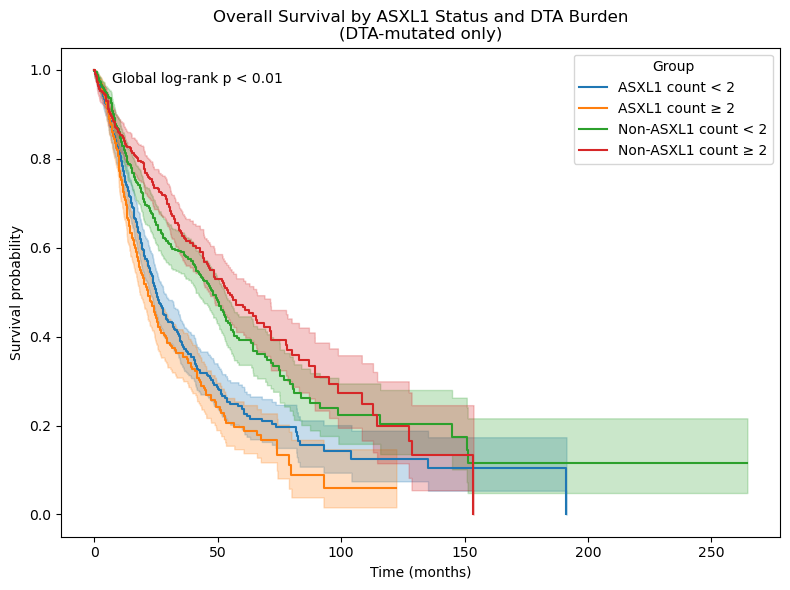

In [158]:
### Log-rank KM plots within ASXL1 vs Non-ASXL1 strata (OS outcome) - DTA-mutated only

import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# Settings
TIME_COL = "os_months"
EVENT_COL = "os_status"

# Copying dataframe for reusing
df = dff.copy()

# Restrict to DTA-mutated cases only
df = df[df["n_dta"] >= 1].copy()

# Define ASXL1 vs Non-ASXL1 and DTA burden groups
df["asxl1_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")
df["burden_group"] = df["n_dta"].apply(lambda x: "n_dta < 2" if x < 2 else "n_dta ≥ 2")

# Combined 4-group variable
df["combo_group"] = df["asxl1_group"] + " & " + df["burden_group"]

# Coerce survival columns
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")

# Keep complete cases
d = df.dropna(subset=[TIME_COL, EVENT_COL, "combo_group"]).copy()

#  Global log-rank test across 4 groups
res_global = multivariate_logrank_test(
    event_durations=d[TIME_COL],
    groups=d["combo_group"],
    event_observed=d[EVENT_COL])
p_global = res_global.p_value
print("Global log-rank p-value (DTA-positive only, 4 groups):", p_global)


#  KM curves for the 4 groups
kmf = KaplanMeierFitter()

# Define group order for consistent plotting
group_order = [
    "ASXL1 & n_dta < 2",
    "ASXL1 & n_dta ≥ 2",
    "Non-ASXL1 & n_dta < 2",
    "Non-ASXL1 & n_dta ≥ 2",]

# Map internal group names -> nice legend labels
pretty_labels = {
    "ASXL1 & n_dta < 2":        "ASXL1 count < 2",
    "ASXL1 & n_dta ≥ 2":        "ASXL1 count ≥ 2",
    "Non-ASXL1 & n_dta < 2":    "Non-ASXL1 count < 2",
    "Non-ASXL1 & n_dta ≥ 2":    "Non-ASXL1 count ≥ 2",}

fig, ax = plt.subplots(figsize=(8, 6))

for grp in group_order:
    sub = d[d["combo_group"] == grp]
    if sub.empty:
        continue  # skip groups that don't exist
    kmf.fit(
        durations=sub[TIME_COL],
        event_observed=sub[EVENT_COL],
        label=grp
    )
    kmf.plot_survival_function(ax=ax, ci_show=True)


# Get the existing legend handles (one per group)
handles, _ = ax.get_legend_handles_labels()

custom_labels = [
    "ASXL1 count < 2",
    "ASXL1 count ≥ 2",
    "Non-ASXL1 count < 2",
    "Non-ASXL1 count ≥ 2",
]

# Force the legend to use our labels
ax.legend(handles[:4], custom_labels, title="Group", loc="best")

ax.set_title("Overall Survival by ASXL1 Status and DTA Burden\n(DTA-mutated only)")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")

# Remove any existing text and add new one
for txt in list(ax.texts):
    txt.remove()

# Add global p-value on the plot
ax.text(0.07, 0.95, f"Global log-rank p < 0.01",transform=ax.transAxes, ha = "left", va = "top")

plt.tight_layout()
plt.savefig(FIGURES / "km_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


In [174]:
### Stats on the plot above with pairwise comparisons - DTA-positive only (OS)

import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from itertools import combinations

# For multiple testing correction (Bonferroni/Holm/FDR)
from statsmodels.stats.multitest import multipletests

#  Basic setup & DTA-only subset

TIME_COL = "os_months"
EVENT_COL = "os_status"

# Start from main dataframe
df = dff.copy()

# Keep only DTA-positive cases
df = df[df["n_dta"] >= 1].copy()

# Coerce time & event to numeric
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")


##  Define groups within DTA-positive--
# ASXL1 vs Non-ASXL1
df["dta_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")

# DTA burden: <2 vs ≥2 (still makes sense because n_dta >= 1 here)
df["burden_group"] = df["n_dta"].apply(lambda x: "n_dta < 2" if x < 2 else "n_dta ≥ 2")

# Combined 4-level group
df["combo_group"] = df["dta_group"] + " & " + df["burden_group"]

# Keep complete cases
d = df.dropna(subset=[TIME_COL, EVENT_COL, "combo_group"]).copy()


# 3) Quick group summary 
summary = (
    d.groupby("combo_group")
     .agg(
         n      = (TIME_COL, "size"),
         events = (EVENT_COL, "sum"),
         median_time = (TIME_COL, "median")
     )
     .reset_index()
)
print("Group summary (DTA-positive only), OS outcome:")
print(summary.to_string(index=False))

## Global log-rank test (4 groups, DTA-only) - OS outcome
results_global = multivariate_logrank_test(
    event_durations=d[TIME_COL],
    groups=d["combo_group"],
    event_observed=d[EVENT_COL]
)
p_global = results_global.p_value
print("\nGlobal log-rank test p-value (DTA-positive only, 4 groups, OS outcome):", p_global)

## Pairwise log-rank tests within DTA-positive cohort - OS outcome
group_order = [
    "ASXL1 & n_dta < 2",
    "ASXL1 & n_dta ≥ 2",
    "Non-ASXL1 & n_dta < 2",
    "Non-ASXL1 & n_dta ≥ 2",
]

pairwise_results = []

for g1, g2 in combinations(group_order, 2):
    d1 = d[d["combo_group"] == g1]
    d2 = d[d["combo_group"] == g2]

    # Skip if a group is empty (can happen if some combos don't exist)
    if d1.empty or d2.empty:
        continue

    res = logrank_test(
        d1[TIME_COL], d2[TIME_COL],
        event_observed_A=d1[EVENT_COL],
        event_observed_B=d2[EVENT_COL]
    )

    pairwise_results.append({
        "group1": g1,
        "group2": g2,
        "p_raw": res.p_value,
        "test_statistic": res.test_statistic,
        "n1": len(d1),
        "n2": len(d2),
    })

df_pairs_dta = pd.DataFrame(pairwise_results)

if not df_pairs_dta.empty:
    # Multiple testing correction (Bonferroni, Holm, FDR)
    pvals = df_pairs_dta["p_raw"].values

    df_pairs_dta["p_bonf"] = multipletests(pvals, method="bonferroni")[1]
    df_pairs_dta["p_holm"] = multipletests(pvals, method="holm")[1]
    df_pairs_dta["p_fdr"]  = multipletests(pvals, method="fdr_bh")[1]

    print("\nPairwise log-rank tests (DTA-positive only), OS outcome:")
    print(df_pairs_dta.sort_values("p_raw").to_string(index=False))
else:
    print("\nNo valid pairwise comparisons (some groups may be empty), OS outcome.")

Group summary (DTA-positive only):
          combo_group   n  events  median_time
    ASXL1 & n_dta < 2 484     302    18.443836
    ASXL1 & n_dta ≥ 2 405     244    14.958904
Non-ASXL1 & n_dta < 2 571     264    23.704110
Non-ASXL1 & n_dta ≥ 2 446     190    27.172603

Global log-rank test p-value (DTA-positive only, 4 groups, OS outcome): 9.376591111606506e-20

Pairwise log-rank tests (DTA-positive only), OS outcome:
               group1                group2        p_raw  test_statistic  n1  n2       p_bonf       p_holm        p_fdr
    ASXL1 & n_dta ≥ 2 Non-ASXL1 & n_dta ≥ 2 6.824402e-16       65.183340 405 446 4.094641e-15 4.094641e-15 4.094641e-15
    ASXL1 & n_dta ≥ 2 Non-ASXL1 & n_dta < 2 7.438740e-12       46.908290 405 571 4.463244e-11 3.719370e-11 2.231622e-11
    ASXL1 & n_dta < 2 Non-ASXL1 & n_dta ≥ 2 6.724800e-11       42.597421 484 446 4.034880e-10 2.689920e-10 1.344960e-10
    ASXL1 & n_dta < 2 Non-ASXL1 & n_dta < 2 1.040776e-07       28.296619 484 571 6.244657e-07 3.1

Global log-rank p-value (DTA-positive only, 4 groups): 4.4725764803698975e-20


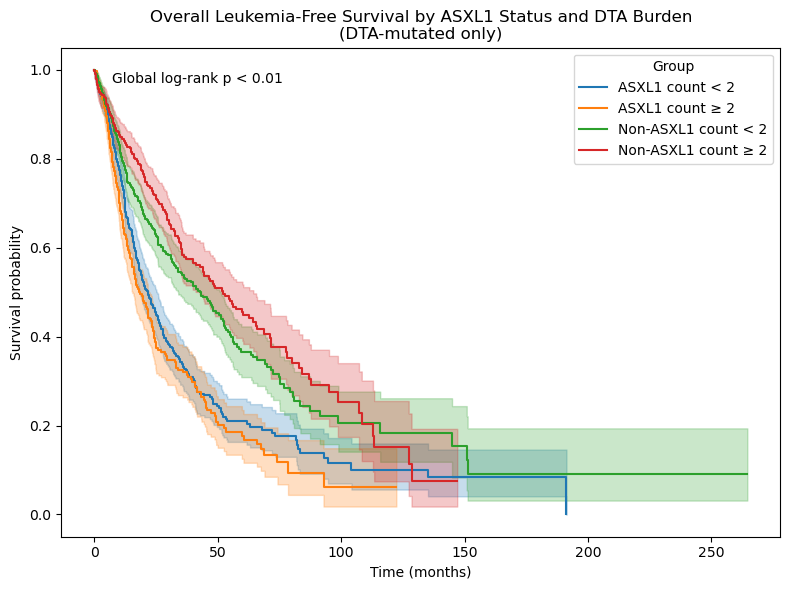

In [170]:
### Log-rank KM plots within ASXL1 vs Non-ASXL1 strata (LFS outcome) - DTA-mutated only

import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test

# Settings
TIME_COL = "lfs_months"
EVENT_COL = "lfs_status"

# Copying dataframe for reusing
df = dff.copy()

# Restrict to DTA-mutated cases only
df = df[df["n_dta"] >= 1].copy()

# Define ASXL1 vs Non-ASXL1 and DTA burden groups
df["asxl1_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")
df["burden_group"] = df["n_dta"].apply(lambda x: "n_dta < 2" if x < 2 else "n_dta ≥ 2")

# Combined 4-group variable
df["combo_group"] = df["asxl1_group"] + " & " + df["burden_group"]

# Coerce survival columns
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")

# Keep complete cases
d = df.dropna(subset=[TIME_COL, EVENT_COL, "combo_group"]).copy()

#  Global log-rank test across 4 groups
res_global = multivariate_logrank_test(
    event_durations=d[TIME_COL],
    groups=d["combo_group"],
    event_observed=d[EVENT_COL])
p_global = res_global.p_value
print("Global log-rank p-value (DTA-positive only, 4 groups), LFS outcome:", p_global)


#  KM curves for the 4 groups
kmf = KaplanMeierFitter()

# Define group order for consistent plotting
group_order = [
    "ASXL1 & n_dta < 2",
    "ASXL1 & n_dta ≥ 2",
    "Non-ASXL1 & n_dta < 2",
    "Non-ASXL1 & n_dta ≥ 2",]

# Map internal group names -> nice legend labels
pretty_labels = {
    "ASXL1 & n_dta < 2":        "ASXL1 count < 2",
    "ASXL1 & n_dta ≥ 2":        "ASXL1 count ≥ 2",
    "Non-ASXL1 & n_dta < 2":    "Non-ASXL1 count < 2",
    "Non-ASXL1 & n_dta ≥ 2":    "Non-ASXL1 count ≥ 2",}

fig, ax = plt.subplots(figsize=(8, 6))

for grp in group_order:
    sub = d[d["combo_group"] == grp]
    if sub.empty:
        continue  # skip groups that don't exist
    kmf.fit(
        durations=sub[TIME_COL],
        event_observed=sub[EVENT_COL],
        label=grp
    )
    kmf.plot_survival_function(ax=ax, ci_show=True)


# Get the existing legend handles (one per group)
handles, _ = ax.get_legend_handles_labels()

custom_labels = [
    "ASXL1 count < 2",
    "ASXL1 count ≥ 2",
    "Non-ASXL1 count < 2",
    "Non-ASXL1 count ≥ 2",
]

# Force the legend to use our labels
ax.legend(handles[:4], custom_labels, title="Group", loc="best")

ax.set_title("Overall Leukemia-Free Survival by ASXL1 Status and DTA Burden\n(DTA-mutated only)")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")

# Remove any existing text and add new one
for txt in list(ax.texts):
    txt.remove()

# Add global p-value on the plot
ax.text(0.07, 0.95, f"Global log-rank p < 0.01",transform=ax.transAxes, ha = "left", va = "top")

plt.tight_layout()
plt.savefig(FIGURES / "km_os.tiff", dpi=300, bbox_inches="tight")
plt.show()


In [175]:
### Stats on the plot above with pairwise comparisons - DTA-positive only (LFS)

import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from itertools import combinations

# For multiple testing correction (Bonferroni/Holm/FDR)
from statsmodels.stats.multitest import multipletests

#  Basic setup & DTA-only subset

TIME_COL = "lfs_months"
EVENT_COL = "lfs_status"

# Start from main dataframe
df = dff.copy()

# Keep only DTA-positive cases
df = df[df["n_dta"] >= 1].copy()

# Coerce time & event to numeric
df[TIME_COL]  = pd.to_numeric(df[TIME_COL], errors="coerce")
df[EVENT_COL] = pd.to_numeric(df[EVENT_COL], errors="coerce")


##  Define groups within DTA-positive--
# ASXL1 vs Non-ASXL1
df["dta_group"] = df["asxl1"].apply(lambda x: "ASXL1" if x == 1.0 else "Non-ASXL1")

# DTA burden: <2 vs ≥2 (still makes sense because n_dta >= 1 here)
df["burden_group"] = df["n_dta"].apply(lambda x: "n_dta < 2" if x < 2 else "n_dta ≥ 2")

# Combined 4-level group
df["combo_group"] = df["dta_group"] + " & " + df["burden_group"]

# Keep complete cases
d = df.dropna(subset=[TIME_COL, EVENT_COL, "combo_group"]).copy()


# 3) Quick group summary 
summary = (
    d.groupby("combo_group")
     .agg(
         n      = (TIME_COL, "size"),
         events = (EVENT_COL, "sum"),
         median_time = (TIME_COL, "median")
     )
     .reset_index()
)
print("Group summary (DTA-positive only), LFS outcome:")
print(summary.to_string(index=False))

## Global log-rank test (4 groups, DTA-only) - LFS outcome
results_global = multivariate_logrank_test(
    event_durations=d[TIME_COL],
    groups=d["combo_group"],
    event_observed=d[EVENT_COL]
)
p_global = results_global.p_value
print("\nGlobal log-rank test p-value (DTA-positive only, 4 groups, LFS outcome):", p_global)

## Pairwise log-rank tests within DTA-positive cohort - OS outcome
group_order = [
    "ASXL1 & n_dta < 2",
    "ASXL1 & n_dta ≥ 2",
    "Non-ASXL1 & n_dta < 2",
    "Non-ASXL1 & n_dta ≥ 2",
]

pairwise_results = []

for g1, g2 in combinations(group_order, 2):
    d1 = d[d["combo_group"] == g1]
    d2 = d[d["combo_group"] == g2]

    # Skip if a group is empty (can happen if some combos don't exist)
    if d1.empty or d2.empty:
        continue

    res = logrank_test(
        d1[TIME_COL], d2[TIME_COL],
        event_observed_A=d1[EVENT_COL],
        event_observed_B=d2[EVENT_COL]
    )

    pairwise_results.append({
        "group1": g1,
        "group2": g2,
        "p_raw": res.p_value,
        "test_statistic": res.test_statistic,
        "n1": len(d1),
        "n2": len(d2),
    })

df_pairs_dta = pd.DataFrame(pairwise_results)

if not df_pairs_dta.empty:
    # Multiple testing correction (Bonferroni, Holm, FDR)
    pvals = df_pairs_dta["p_raw"].values

    df_pairs_dta["p_bonf"] = multipletests(pvals, method="bonferroni")[1]
    df_pairs_dta["p_holm"] = multipletests(pvals, method="holm")[1]
    df_pairs_dta["p_fdr"]  = multipletests(pvals, method="fdr_bh")[1]

    print("\nPairwise log-rank tests (DTA-positive only), LFS outcome:")
    print(df_pairs_dta.sort_values("p_raw").to_string(index=False))
else:
    print("\nNo valid pairwise comparisons (some groups may be empty), LFS outcome.")

Group summary (DTA-positive only), LFS outcome:
          combo_group   n  events  median_time
    ASXL1 & n_dta < 2 424     277    15.978082
    ASXL1 & n_dta ≥ 2 358     225    12.641096
Non-ASXL1 & n_dta < 2 498     250    22.241096
Non-ASXL1 & n_dta ≥ 2 401     178    24.624658

Global log-rank test p-value (DTA-positive only, 4 groups, LFS outcome): 4.4725764803698975e-20

Pairwise log-rank tests (DTA-positive only), LFS outcome:
               group1                group2        p_raw  test_statistic  n1  n2       p_bonf       p_holm        p_fdr
    ASXL1 & n_dta ≥ 2 Non-ASXL1 & n_dta ≥ 2 3.175322e-16       66.691307 358 401 1.905193e-15 1.905193e-15 1.905193e-15
    ASXL1 & n_dta < 2 Non-ASXL1 & n_dta ≥ 2 9.889551e-12       46.350238 424 401 5.933731e-11 4.944776e-11 2.966865e-11
    ASXL1 & n_dta ≥ 2 Non-ASXL1 & n_dta < 2 2.679358e-11       44.398182 358 498 1.607615e-10 1.071743e-10 5.358716e-11
    ASXL1 & n_dta < 2 Non-ASXL1 & n_dta < 2 9.361586e-08       28.501708 424 498 